In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install h5py==2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: Could not build wheels for h5py, which is required to install pyproject.toml-based projects


In [ ]:
import tensorflow as tf
print("tensorflow version :{}".format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tensorflow version :2.15.0
Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11450874319482175313
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10364416409184820908
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#### physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

In [ ]:

from keras.layers import Conv1D, Dense, Dropout, GlobalMaxPool1D, MaxPool1D
from keras.layers import TimeDistributed, LSTM, Bidirectional, Input, concatenate,RepeatVector
from keras import regularizers
# from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.regularizers import l1,l2
from statsmodels.tsa.stattools import adfuller


In [ ]:
data_path = '/content/drive/MyDrive/CAV/data/Drift attack/Mag_0_2_dur_20/'

In [ ]:
sensor1_data = pd.read_csv(data_path + "Sensor1_values_drift_0_2.csv",index_col = "Unnamed: 0")
sensor1_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
len(sensor1_data)

29800

In [ ]:
sensor1_label = pd.read_csv(data_path + "Ground_truth_drift_0_2_dur_20_sensor1.csv", names=['Class'] )
sensor1_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
len(sensor1_label)

29800

In [ ]:
sensor2_data = pd.read_csv(data_path + "Sensor2_values_drift_0_2.csv", index_col = "Unnamed: 0")
sensor2_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor2_label = pd.read_csv(data_path + "Ground_truth_drift_0_2_dur_20_sensor2.csv", names=['Class'] )
sensor2_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor3_data = pd.read_csv(data_path + "Sensor3_values_drift_0_2.csv", index_col = "Unnamed: 0")
sensor3_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor3_label = pd.read_csv(data_path + "Ground_truth_drift_0_2_dur_20_sensor3.csv", names=['Class'] )
sensor3_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor1_data['minus_speed'] = sensor1_data['InVehicle_Longitudinal_Speed']-sensor1_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor1_data['minus_acc'] = sensor1_data['InVehicle_Longitudinal_Accel']-sensor1_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor1_data['minus_Gps'] = sensor1_data['GPS_Speed']-sensor1_data['GPS_Speed'].shift(1)


In [ ]:
sensor2_data['minus_speed'] = sensor2_data['InVehicle_Longitudinal_Speed']-sensor2_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor2_data['minus_acc'] = sensor2_data['InVehicle_Longitudinal_Accel']-sensor2_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor2_data['minus_Gps'] = sensor2_data['GPS_Speed']-sensor2_data['GPS_Speed'].shift(1)


In [ ]:
sensor3_data['minus_speed'] = sensor3_data['InVehicle_Longitudinal_Speed']-sensor3_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor3_data['minus_acc'] = sensor3_data['InVehicle_Longitudinal_Accel']-sensor3_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor3_data['minus_Gps'] = sensor3_data['GPS_Speed']-sensor3_data['GPS_Speed'].shift(1)


In [ ]:
sensor1_data.dropna(inplace= True)
sensor2_data.dropna(inplace= True)
sensor3_data.dropna(inplace= True)


array([<Axes: >, <Axes: >], dtype=object)

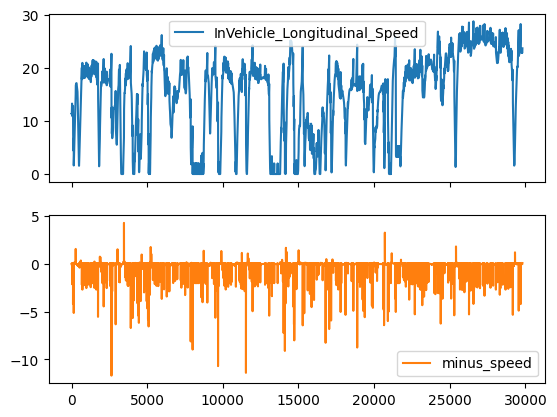

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

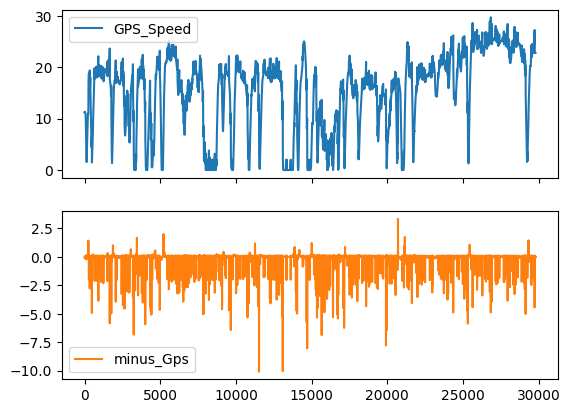

In [ ]:
sensor1_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

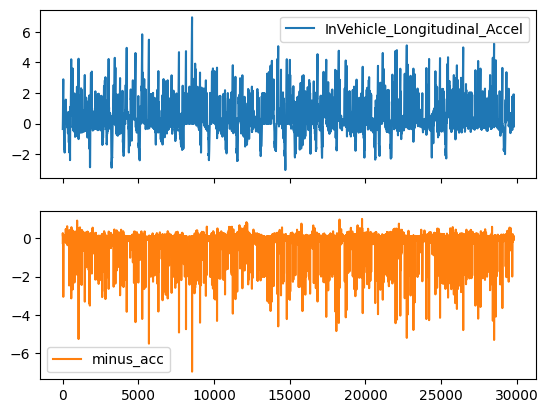

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor1_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor1_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor1_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 0.0
stationary_gps :9.330183517785544e-30
stationary_acc :0.0



array([<Axes: >, <Axes: >], dtype=object)

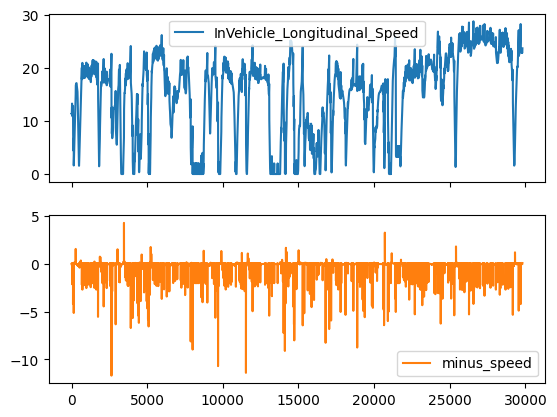

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

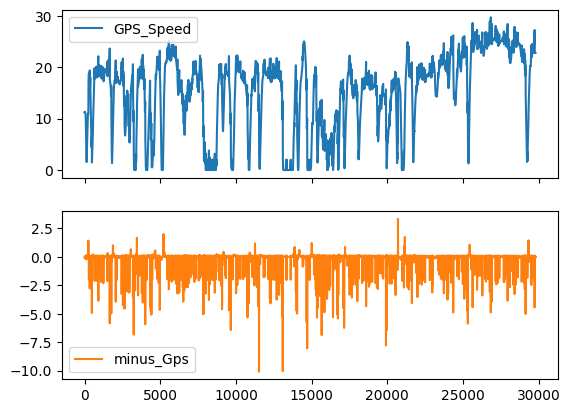

In [ ]:
sensor2_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

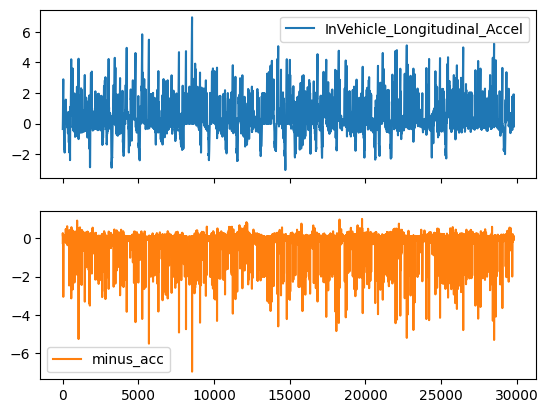

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor2_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor2_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor2_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 0.0
stationary_gps :9.330183517785544e-30
stationary_acc :0.0



array([<Axes: >, <Axes: >], dtype=object)

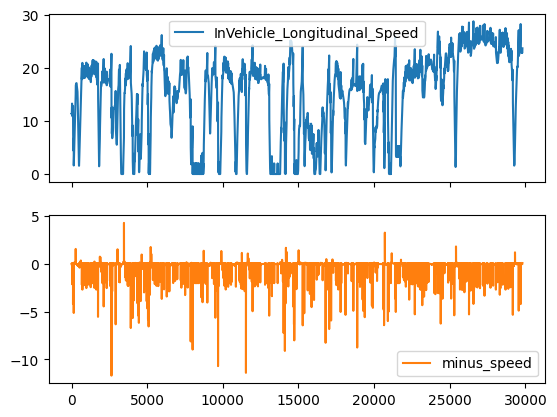

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

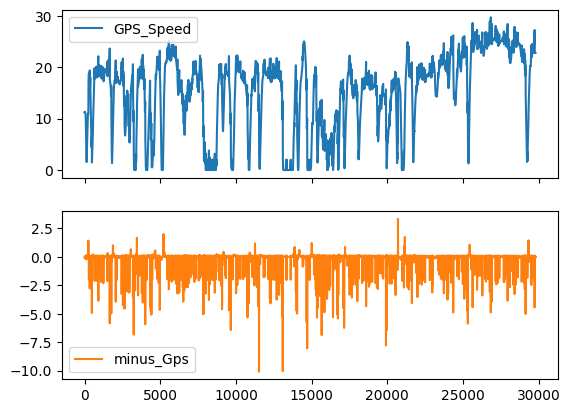

In [ ]:
sensor3_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

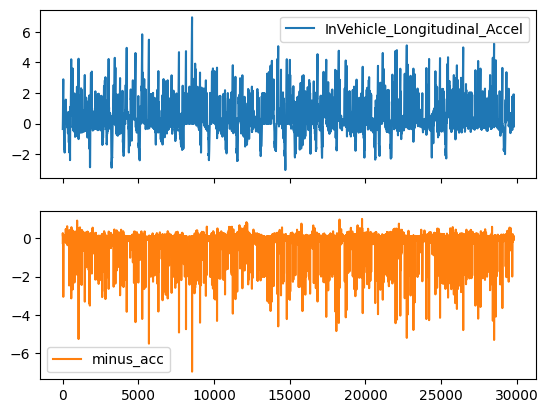

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor3_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor3_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor3_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 0.0
stationary_gps :9.330183517785544e-30
stationary_acc :0.0



In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal = scaler.transform(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal[:5]

array([[-0.02407934, -0.15741775, -0.83513554],
       [-0.01325172, -0.02210329,  0.87474264],
       [-0.0112855 ,  0.04210332,  0.15778633],
       [-0.00645397,  0.02045952,  0.01937871],
       [-0.00442347, -0.04645208, -0.00739969]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal = scaler.transform(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal[:5]

array([[-0.02407934, -0.15741775, -0.83513554],
       [-0.01325172, -0.02210329,  0.87474264],
       [-0.0112855 ,  0.04210332,  0.15778633],
       [-0.00645397,  0.02045952,  0.01937871],
       [-0.00442347, -0.04645208, -0.00739969]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal = scaler.transform(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal[:5]

array([[-0.02407934, -0.15741775, -0.83513554],
       [-0.01325172, -0.02210329,  0.87474264],
       [-0.0112855 ,  0.04210332,  0.15778633],
       [-0.00645397,  0.02045952,  0.01937871],
       [-0.00442347, -0.04645208, -0.00739969]])

In [ ]:
window_size = 10

# create windows with overlap
def convertToFrames(X_data,y_data, step):
    X, Y =[], []
    for i in range(len(X_data)-step):
        y_or = 0
        d=i+step
        X.append(X_data[i:d,])
        for y in y_data.iloc[i:d].values:
           y_or = y_or or y

        Y.append(y_or)
    return np.array(X), np.array(Y)

In [ ]:
X_sensor1, y_sensor1 = convertToFrames(sensor1_data_normal, sensor1_label, window_size)
X_sensor1.shape, y_sensor1.shape
# print(X_sensor1[0])
# print(X_sensor1[1])

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor2, y_sensor2 = convertToFrames(sensor2_data_normal, sensor2_label, window_size)
X_sensor2.shape, y_sensor2.shape

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor3, y_sensor3 = convertToFrames(sensor3_data_normal, sensor3_label, window_size)
X_sensor3.shape, y_sensor3.shape

((29789, 10, 3), (29789, 1))

In [ ]:
y_sensor1 = to_categorical(y_sensor1, num_classes= 2, dtype='float32')
y_sensor2 = to_categorical(y_sensor2, num_classes= 2, dtype='float32')
y_sensor3 = to_categorical(y_sensor3, num_classes= 2, dtype='float32')
y_sensor1.shape, y_sensor2.shape, y_sensor3.shape

((29789, 2), (29789, 2), (29789, 2))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(X_sensor1):
    # Split the data based on the indices
    X_train_sensor1, X_test_sensor1 = X_sensor1[train_index], X_sensor1[test_index]
    y_train_sensor1, y_test_sensor1 = y_sensor1[train_index], y_sensor1[test_index]

for train_index, test_index in tscv.split(X_sensor2):
    # Split the data based on the indices
    X_train_sensor2, X_test_sensor2 = X_sensor2[train_index], X_sensor2[test_index]
    y_train_sensor2, y_test_sensor2 = y_sensor2[train_index], y_sensor2[test_index]

for train_index, test_index in tscv.split(X_sensor3):
    # Split the data based on the indices
    X_train_sensor3, X_test_sensor3 = X_sensor3[train_index], X_sensor3[test_index]
    y_train_sensor3, y_test_sensor3 = y_sensor3[train_index], y_sensor3[test_index]

In [ ]:
X_train_sensor1.shape, X_test_sensor1.shape,y_train_sensor1.shape, y_test_sensor1.shape

((27081, 10, 3), (2708, 10, 3), (27081, 2), (2708, 2))

In [ ]:
X_train_sensor2.shape, X_test_sensor2.shape,y_train_sensor2.shape, y_test_sensor2.shape

((27081, 10, 3), (2708, 10, 3), (27081, 2), (2708, 2))

In [ ]:
X_train_sensor3.shape, X_test_sensor3.shape,y_train_sensor3.shape, y_test_sensor3.shape

((27081, 10, 3), (2708, 10, 3), (27081, 2), (2708, 2))

In [ ]:

def creatModel():

    model = Sequential()
    model.add(Conv1D(kernel_size=3, filters= 40, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    model.add( Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    #model.add(Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    #model.add(Dropout(0.1))
    model.add(GlobalMaxPool1D())
    model.add(RepeatVector(X_train_sensor1.shape[1]))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(rate=0.2))
    #model.add(LSTM(128, return_sequences=True))
    #model.add(Dropout(rate=0.2))
    #model.add(LSTM(64, return_sequences=False))
    #model.add(Dropout(rate=0.2))
    model.add((Dense(32)))
    model.add((Dense(16)))
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2()))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

    return model


In [ ]:
import time

class TimeHistory(Callback):

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        logs['epoch_time'] = epoch_time


In [ ]:
# Function to calculate prediction time
def calculate_prediction_time(model, X_data):
    start_time = time.time()
    predictions = model.predict(X_data)
    end_time = time.time()
    prediction_time = end_time - start_time
    return prediction_time, predictions


In [ ]:
model_path = '/content/drive/MyDrive/CAV/data/Drift attack/Mag_0_2_dur_20/Models/Models16-1-KF-CNN-40-60-LSTM-256/'

class Model_save(Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save(model_path + "D-CNN-LSTM-autoEncoder-Drift-0_2_dur_20-CAV-perEpoch_{}.h5".format(sensor))


In [ ]:
def setCallbacks(sensor):

  best_model_path = model_path + 'Best_D-CNN-LSTM-autoEncoder-Drift-0_2_dur_20-CAV_{}.h5'.format(sensor)
  checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

  history_cb = tf.keras.callbacks.CSVLogger(model_path + 'historyLOG_Drift-0_2_dur_20_{}.csv'.format(sensor), separator=",", append=True)

  model_save = Model_save()

  Estop = EarlyStopping(monitor='val_accuracy', patience= 100)

  return model_save, checkpoint, history_cb, Estop

In [ ]:
sensor = "sensor1"
time_callback = TimeHistory()
model_sensor1 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor1")
history_sensor1 = model_sensor1.fit(X_train_sensor1, y_train_sensor1,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#


Epoch 1/500
191/191 [==============================] - 10s 11ms/step - loss: 0.3164 - accuracy: 0.8609 - val_loss: 0.1489 - val_accuracy: 0.9472 - epoch_time: 10.2165
Epoch 2/500
  9/191 [>.............................] - ETA: 1s - loss: 0.1586 - accuracy: 0.9410

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 1s 7ms/step - loss: 0.1446 - accuracy: 0.9460 - val_loss: 0.0772 - val_accuracy: 0.9900 - epoch_time: 1.2502
Epoch 3/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1086 - accuracy: 0.9584 - val_loss: 0.1056 - val_accuracy: 0.9642 - epoch_time: 1.2602
Epoch 4/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0886 - accuracy: 0.9674 - val_loss: 0.0797 - val_accuracy: 0.9742 - epoch_time: 1.2722
Epoch 5/500
191/191 [==============================] - 2s 8ms/step - loss: 0.0781 - accuracy: 0.9722 - val_loss: 0.0379 - val_accuracy: 0.9959 - epoch_time: 1.4330
Epoch 6/500
191/191 [==============================] - 2s 9ms/step - loss: 0.0711 - accuracy: 0.9738 - val_loss: 0.0606 - val_accuracy: 0.9845 - epoch_time: 1.7038
Epoch 7/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0700 - accuracy: 0.9745 - val_loss: 0.0510 - val_accuracy: 0.9849 - epoch_time: 1.3099
Epoch 8/500
191/191 [=======

In [ ]:
print(model_sensor1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 40)            400       
                                                                 
 dropout (Dropout)           (None, 10, 40)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 60)            7260      
                                                                 
 dropout_1 (Dropout)         (None, 10, 60)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 60)                0         
 alMaxPooling1D)                                                 
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 60)            0         
 r)                                                     

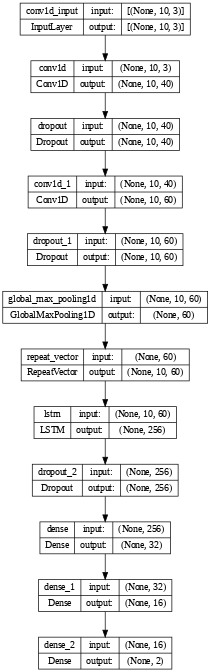

In [ ]:
plot_model(model= model_sensor1, show_shapes= True, dpi=50)

In [ ]:
sensor = "sensor2"
time_callback = TimeHistory()
model_sensor2 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor2")
history_sensor2 = model_sensor2.fit(X_train_sensor2, y_train_sensor2,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#

Epoch 1/500
191/191 [==============================] - 5s 10ms/step - loss: 0.3087 - accuracy: 0.8760 - val_loss: 0.1438 - val_accuracy: 0.9483 - epoch_time: 4.9474
Epoch 2/500
191/191 [==============================] - 2s 9ms/step - loss: 0.1451 - accuracy: 0.9455 - val_loss: 0.1324 - val_accuracy: 0.9402 - epoch_time: 1.6637
Epoch 3/500
191/191 [==============================] - 2s 10ms/step - loss: 0.1035 - accuracy: 0.9623 - val_loss: 0.1042 - val_accuracy: 0.9542 - epoch_time: 1.7199
Epoch 4/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0867 - accuracy: 0.9698 - val_loss: 0.0746 - val_accuracy: 0.9723 - epoch_time: 1.2869
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0732 - accuracy: 0.9721 - val_loss: 0.0796 - val_accuracy: 0.9749 - epoch_time: 1.2968
Epoch 6/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0679 - accuracy: 0.9742 - val_loss: 0.0672 - val_accuracy: 0.9790 - epoch_time: 1.2875
Epoch 7/500
19

In [ ]:
sensor = "sensor3"
time_callback = TimeHistory()
model_sensor3 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor3")
history_sensor3 = model_sensor3.fit(X_train_sensor3, y_train_sensor3,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#

Epoch 1/500
191/191 [==============================] - 6s 10ms/step - loss: 0.3024 - accuracy: 0.8881 - val_loss: 0.2026 - val_accuracy: 0.9391 - epoch_time: 6.1651
Epoch 2/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1686 - accuracy: 0.9457 - val_loss: 0.1280 - val_accuracy: 0.9557 - epoch_time: 1.2602
Epoch 3/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1201 - accuracy: 0.9595 - val_loss: 0.1029 - val_accuracy: 0.9716 - epoch_time: 1.2794
Epoch 4/500
191/191 [==============================] - 1s 8ms/step - loss: 0.0919 - accuracy: 0.9696 - val_loss: 0.0773 - val_accuracy: 0.9705 - epoch_time: 1.3321
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0782 - accuracy: 0.9735 - val_loss: 0.0644 - val_accuracy: 0.9767 - epoch_time: 1.2437
Epoch 6/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0702 - accuracy: 0.9767 - val_loss: 0.0658 - val_accuracy: 0.9767 - epoch_time: 1.2604
Epoch 7/500
191

In [ ]:
#plot history of model_sensor1
history_sensor1 = pd.read_csv(model_path +"historyLOG_Drift-0_2_dur_20_sensor1.csv", index_col='epoch')
history_sensor1.reset_index(drop= True, inplace= True)
history_sensor1.head()
print('Average Exe_time for sensor1: {} sec.'.format(round(np.mean(history_sensor1['epoch_time'].values),3)))


Average Exe_time for sensor1: 1.487 sec.


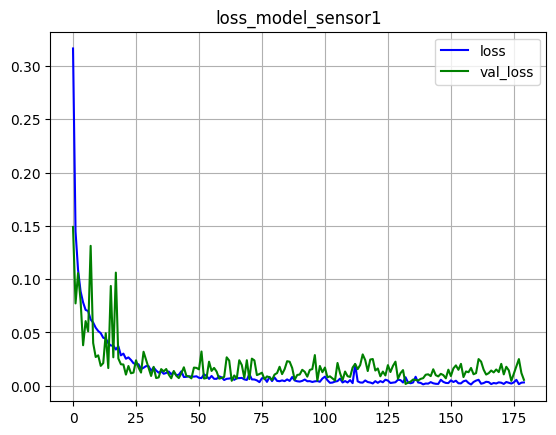

In [ ]:
plt.plot( history_sensor1['loss'], 'b',label = 'loss')
plt.plot( history_sensor1['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor1')
plt.show()

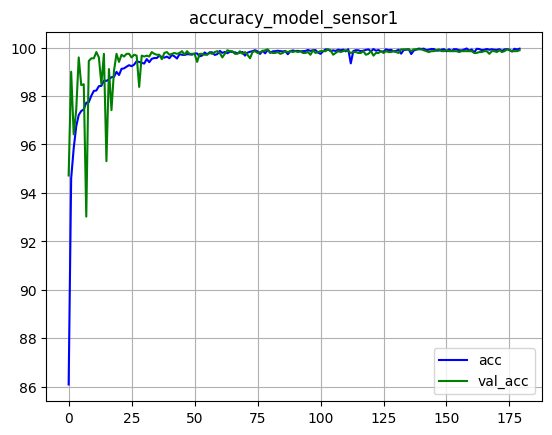

In [ ]:
plt.plot(history_sensor1['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor1['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor1')
plt.show()

In [ ]:
history_sensor2 = pd.read_csv(model_path +"historyLOG_Drift-0_2_dur_20_sensor2.csv", index_col='epoch')
history_sensor2.reset_index(drop= True, inplace= True)
history_sensor2.head()
print('Average Exe_time for sensor2: {} sec.'.format(round(np.mean(history_sensor2['epoch_time'].values),3)))


Average Exe_time for sensor2: 1.451 sec.


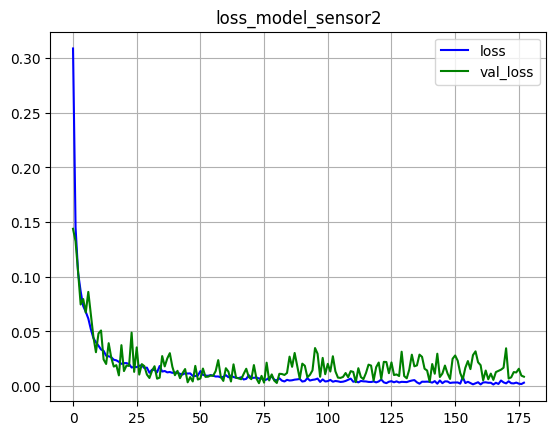

In [ ]:
plt.plot( history_sensor2['loss'], 'b',label = 'loss')
plt.plot( history_sensor2['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor2')
plt.show()

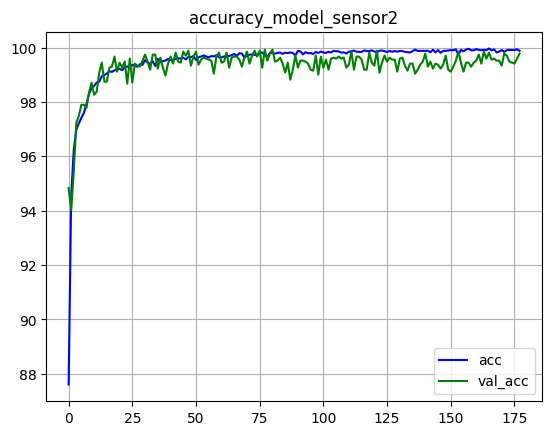

In [ ]:
plt.plot(history_sensor2['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor2['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor2')
plt.show()

In [ ]:
history_sensor3 = pd.read_csv(model_path +"historyLOG_Drift-0_2_dur_20_sensor3.csv", index_col='epoch')
history_sensor3.reset_index(drop= True, inplace= True)
history_sensor3.head()
print('Average Exe_time for sensor3: {} sec.'.format(round(np.mean(history_sensor3['epoch_time'].values),3)))


Average Exe_time for sensor3: 1.458 sec.


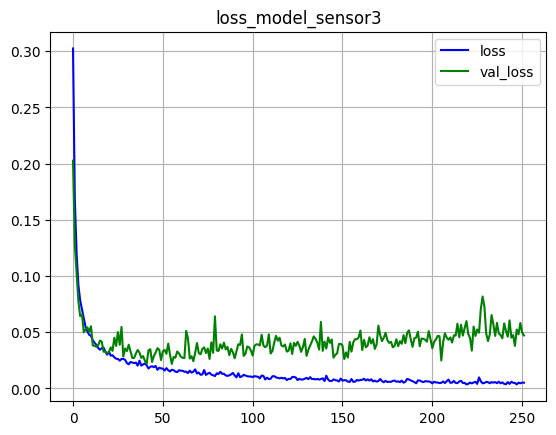

In [ ]:
plt.plot( history_sensor3['loss'], 'b',label = 'loss')
plt.plot( history_sensor3['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor3')
plt.show()

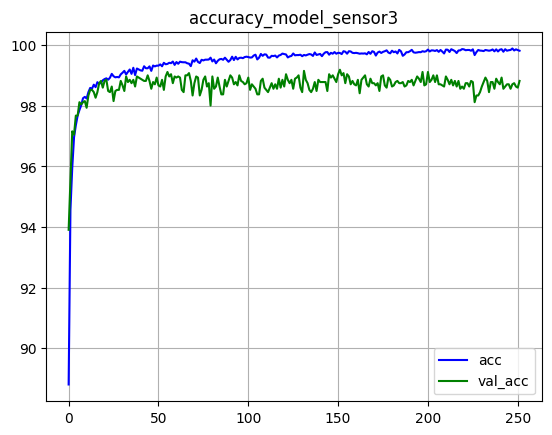

In [ ]:
plt.plot(history_sensor3['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor3['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor3')
plt.show()

In [ ]:
# Calculate prediction time for sensor1
prediction_time_sensor1, _ = calculate_prediction_time(model_sensor1, X_test_sensor1)
print(f'Prediction time for sensor1: {prediction_time_sensor1} seconds')

85/85 [==============================] - 1s 4ms/step
Prediction time for sensor1: 1.874293565750122 seconds


In [ ]:
# Calculate prediction time for sensor2
prediction_time_sensor2, _ = calculate_prediction_time(model_sensor2, X_test_sensor2)
print(f'Prediction time for sensor2: {prediction_time_sensor2} seconds')

85/85 [==============================] - 1s 2ms/step
Prediction time for sensor2: 0.7209930419921875 seconds


In [ ]:
# Calculate prediction time for sensor3
prediction_time_sensor3, _ = calculate_prediction_time(model_sensor3, X_test_sensor3)
print(f'Prediction time for sensor3: {prediction_time_sensor3} seconds')

85/85 [==============================] - 1s 3ms/step
Prediction time for sensor3: 1.0479702949523926 seconds


In [ ]:
#last model_sensor1 evaluation
test_loss, test_acc = model_sensor1.evaluate( X_test_sensor1, y_test_sensor1, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 4ms/step - loss: 0.0199 - accuracy: 0.9948
test accuracy :99.5% 
 test loss :0.0199


In [ ]:
#last model_sensor2 evaluation
test_loss, test_acc = model_sensor2.evaluate( X_test_sensor2, y_test_sensor2, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 4ms/step - loss: 0.0125 - accuracy: 0.9974
test accuracy :99.7% 
 test loss :0.0125


In [ ]:
#last model_sensor3 evaluation
test_loss, test_acc = model_sensor3.evaluate( X_test_sensor3, y_test_sensor3, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 4ms/step - loss: 0.0254 - accuracy: 0.9937
test accuracy :99.4% 
 test loss :0.0254


In [ ]:
y_pred_sensor1 = model_sensor1.predict( X_test_sensor1, verbose= 1)
y_pred_sensor2 = model_sensor2.predict( X_test_sensor2, verbose= 1)
y_pred_sensor3 = model_sensor3.predict( X_test_sensor3, verbose= 1)

85/85 [==============================] - 0s 4ms/step


In [ ]:
y_pred_sensor1 = [np.argmax(i) for i in y_pred_sensor1]
y_pred_sensor2 = [np.argmax(i) for i in y_pred_sensor2]
y_pred_sensor3 = [np.argmax(i) for i in y_pred_sensor3]

In [ ]:
y_pred_total = []
for i in range(len(y_pred_sensor1)):
  y_pred_total.append( y_pred_sensor1[i] or y_pred_sensor2[i] or y_pred_sensor3[i])

In [ ]:
assert(len(y_pred_total) == len(y_pred_sensor1))

In [ ]:
y_test_sensor1 = [np.argmax(i) for i in y_test_sensor1]
y_test_sensor2 = [np.argmax(i) for i in y_test_sensor2]
y_test_sensor3 = [np.argmax(i) for i in y_test_sensor3]

In [ ]:
y_test_total = []
for i in range(len(y_test_sensor1)):
  y_test_total.append(y_test_sensor1[i] or y_test_sensor2[i] or y_test_sensor3[i])

In [ ]:
print("Sensor 1 performanace:")
recall = recall_score(y_test_sensor1, y_pred_sensor1, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor1, y_pred_sensor1, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor1, y_pred_sensor1, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor1, y_pred_sensor1)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 1 performanace:
recall score : 99.48%

precision score: 99.48%

F1 score: 99.48%

accuracy score: 99.48%



In [ ]:
print("Sensor 2 performanace:")
recall = recall_score(y_test_sensor2, y_pred_sensor2, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor2, y_pred_sensor2, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor2, y_pred_sensor2, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor2, y_pred_sensor2)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 2 performanace:
recall score : 99.74%

precision score: 99.74%

F1 score: 99.74%

accuracy score: 99.74%



In [ ]:
print("Sensor 3 performanace:")
recall = recall_score(y_test_sensor3, y_pred_sensor3, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor3, y_pred_sensor3, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor3, y_pred_sensor3, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor3, y_pred_sensor3)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 3 performanace:
recall score : 99.37%

precision score: 99.37%

F1 score: 99.37%

accuracy score: 99.37%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_total, y_pred_total, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_total, y_pred_total, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_total, y_pred_total, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_total, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 99.41%

precision score: 99.41%

F1 score: 99.41%

accuracy score: 99.41%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_total, y_pred_total, average='macro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_total, y_pred_total, average='macro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_total, y_pred_total, average='macro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_total, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 99.30%

precision score: 99.22%

F1 score: 99.26%

accuracy score: 99.41%



In [ ]:
conf = confusion_matrix(y_test_total, y_pred_total, labels=[1,0])
conf_df = pd.DataFrame(conf, columns= [1,0], index= [1,0])
conf_df

,1,0
1,1948,9
0,7,744
